In [1]:
import numpy as np
import os
import random
import math
import cmath
import multiprocessing
import random
import time
import matplotlib
import keras
import tensorflow as tf
from tensorflow.keras import backend as K 
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import h5py
from datetime import datetime
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard, LambdaCallback
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    UpSampling2D,
    Dropout
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from keras import Model

In [2]:
import cv2
from scipy.io import loadmat
# Extract axis information to produce cone-shape images
def extract_axis(datapath, axisPath):
    data = loadmat(datapath)

    xaxis = np.array(list(data['xAxis']))
    yaxis = np.array(list(data['zAxis']))

    xaxis = cv2.resize(xaxis, (80, 256), interpolation=cv2.INTER_AREA)
    yaxis = cv2.resize(yaxis, (80, 256), interpolation=cv2.INTER_AREA)

    xaxis += 100
    yaxis -= 4

    print("saved axis info in : {}".format(axisPath))
    np.save(os.path.join(axisPath, "xAxis.npy"), xaxis)
    np.save(os.path.join(axisPath, "yAxis.npy"), yaxis)
    
    return xaxis, yaxis

In [3]:
# extract generic axis information
axisPath = "/DATA/phan92/notebooks"
rand_input_file = "/DATA/phan92/test_resource/raw_data/DoD110/DoD110_Ter002_LO1_Displacement_Normalized_3.mat"
xAxis, yAxis = extract_axis(rand_input_file, axisPath)

saved axis info in : /DATA/phan92/notebooks


In [4]:
def one_hot(label, num_classes=2):
    """
    Create one hot label from the provided label
    
    Args:
        label: label of shape (N, x_dim, y_dim)
        num_classes (int): number of classes to resolve
        
    Returns:
        label: onehot label (N, x_dim, y_dim, n_channels)
    """
    if num_classes == 2:
        # create label to find brain tissue
        # if the probability of brain is >= 0.5
        # set the label to 1, 0 otherwise
        label = np.where(label >= 0.5, 1, 0)
    else:
        # create label to find bleed
        # if the probability of bleed is >= 0.3
        # set the label to 1
        label = np.where(label >= 1.3, 1, 0)

    label = np.expand_dims(label, axis=3)
    #label = np.moveaxis(label, 3, 1)
    
    return label

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Read saved data and provide it to the model in batches
    """
    
    def __init__(self, group: h5py.Group, batch_size=32):
        self.x_dset: h5py.Dataset = group['x']
        self.y_dset: h5py.Dataset = group['y']
        self.batch_size = batch_size
    
    
    def __len__(self):
        """
        Get the numner of batches per epoch
        """
        return int(np.floor(self.x_dset.shape[0] / self.batch_size))
    
    
    def on_epoch_end(self):
        pass
    
    
    def __getitem__(self, batch_index:int):
        """
        Generate one batch of data
        :param batch_index: index of this batch
        :return: the data x and label y of the batch
        """
        batch_start = batch_index * self.batch_size
        batch_end = batch_start + self.batch_size

        x = self.x_dset[batch_start : batch_end]
        y = one_hot(self.y_dset[batch_start : batch_end])
        
        return x, y

In [6]:
def dice_coefficient(y_true, y_pred, epsilon = 0.00001):
    """
    Compute mean dice coefficient over all class
    
    Args:
        y_true (Tensorflow tensor): tensor of ground truth
                                    shape: (x_dim, y_dim, num_class)
        y_pred (Tensorflow tensor): tensor of soft prediction for all classes
                                    shape: (x_dim, y_dim, num_class)
        epsilon (float): small constant added to avoid divide by 0 error
    Return:
        dice_coefficient (float): computed value of dice coefficient
    """
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    dice_numerator = 2. * K.sum(y_true_f * y_pred_f, axis=-1) + epsilon
    dice_denominator = K.sum(y_true_f, axis=-1) + K.sum(y_pred_f, axis=-1) + epsilon
    dice_coefficient = K.mean(dice_numerator / dice_denominator)
    
    return dice_coefficient

In [7]:
def iou(y_true, y_pred, epsilon=0.00001):
    """
    """
    pass

In [8]:
def soft_dice_loss(y_true, y_pred, epsilon=0.00001):
    """
    Compute mean soft dice loss over all classes
    Soft dice loss operate on float probability output
    
    Args:
        y_true (Tensorflow tensor): tensor of ground truth
                                    shape: (x_dim, y_dim, num_class)
        y_pred (Tensorflow tensor): tensor of soft prediction for all classes
                                    shape: (x_dim, y_dim, num_class)
        epsilon (float): small constant added to avoid divide by 0 error
        
    Return:
        dice_loss (float): computed value of dice loss
    """
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    dice_numerator = 2. * K.sum(y_true_f * y_pred_f, axis=-1) + epsilon
    dice_denominator = K.sum(y_true_f**2, axis=-1) + K.sum(y_pred_f**2, axis=-1) + epsilon
    dice_loss = 1. - K.mean(dice_numerator / dice_denominator)
    
    return dice_loss

In [9]:
def build_unet_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [10]:
def train(model, hdf5_file: str, checkpoint_dir: str, log_dir: str, epochs=50):
        """
        Trains UNet model with data contained in given HDF5 file and saves
        trained model to the checkpoint directory after each epoch
        
        Args:
            hdf5_file: Path of hdf5 file which contains the dataset
            checkpoint_dir (str): Directory where checkpoints are saved
            log_dir (str): Directory where logs are saved
            epochs (int): number of epochs
        """
        dataset = h5py.File(hdf5_file, 'r')
        
        training_generator = DataGenerator(dataset['dev'])
        validation_generator = DataGenerator(dataset['test'])
        
        # callback for tensorboard logs
        log_dir = os.path.join(log_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
        os.makedirs(log_dir)
        tb_callback = TensorBoard(log_dir=log_dir, write_images=True)
        
        # callback to save trained model weights
        checkpoint_dir = os.path.join(checkpoint_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
        os.makedirs(checkpoint_dir)
        weights_file = os.path.join(checkpoint_dir, 'unet.weights.epoch_{epoch:02d}.hdf5')
        checkpoint = ModelCheckpoint(weights_file, verbose=1)
        
        model.fit(training_generator,
                  validation_data=validation_generator,
                  callbacks=[tb_callback, checkpoint],
                  epochs=epochs)
        
        dataset.close()

In [11]:
def cross_validation(num_folds, hdf5_file, epochs=50):
    """
    Perform kfold cross validation on the training set
    
    Args:
        num_folds (int): k in kfold
        hdf5 (string): path to hdf5 dataset
        epochs (int): number of epochs to train for
        
    Returns:
        loss_per_fold: list of loss values
        dice_per_fold: list of dice coefficient
    """
    dice_per_fold = []
    loss_per_fold = []
    
    # get data
    f = h5py.File(hdf5_file, 'r')
    dev = f['dev']
    x = dev['x']
    y = dev['y']
    
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=num_folds, shuffle=True)
    
    fold_no = 1
    for train, test in kfold.split(x, y):
        
        # build model
        input_layer = Input((256, 80, 1))
        output_layer = build_unet_model(input_layer, 16)
        model = Model(input_layer, output_layer)
        model.compile(optimizer='adam', loss=soft_dice_loss, metrics=[dice_coefficient])
        
        print("Training for fold", fold_no, "....")
        history = model.fit(x[train], y[train], batch_size=32, epochs=epochs)
        score = model.evaluate(x[test], y[test])
        print("Score for fold", fold_no, ": Dice loss =", score[0], ", Dice score = ", score[1])
        loss_per_fold.append(score[0])
        dice_per_fold.append(score[1])
        
        fold_no += 1
        
    f.close()
    
    return loss_per_fold, dice_per_fold

In [12]:
def visualize_result(label, prediction, displacement, name, xAxis, yAxis):
    """
    Display an input
    
    Args:
        label (numpy.arr): the label
        prediction (numpy.arr): the prediction
        displacement (numpy.arr): displacement
        name (string): name of the data file
        xAxis (numpy.arr): numpy array contain x axis for display the cone
        yAxis (numpy.arr): numpy array contain y axis for display the cone
    """
    prediction = np.squeeze(np.squeeze(prediction, axis=-1), axis=0)
    displacement = np.squeeze(displacement, axis=-1)
    # display
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    fig.suptitle(name, fontsize=16)
    # label
    ax[0].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma')
    ax[0].title.set_text("Ground Truth")
    # prediction
    ax[1].pcolormesh(xAxis, -yAxis, prediction, shading='auto', cmap='magma')
    ax[1].title.set_text("Prediction")
    # displacement
    ax[2].pcolormesh(xAxis, -yAxis, displacement, shading='auto')
    ax[2].title.set_text("Standardized Displacement")
    plt.show()

In [13]:
def show_prediction(model, dataset, sample_num):
    x = dataset['x']
    y = dataset['y']
    names = dataset['filename']
    name = names[sample_num]
    sample = x[sample_num]
    y_true = y[sample_num]
    y_pred = model.predict(np.expand_dims(sample, axis=0))
    visualize_result(y_true, y_pred, sample, name.decode('utf-8'), xAxis, yAxis)

In [14]:
def show_specific_prediction(file_name:str, data_dir, model):
    """
    Make a prediction for a specific file
    
    Args:
        file_name: name of the .mat file (utf-8)
        data_dir: location of the saved dataset
        model: a trained model
    """
    data = h5py.File(data_dir)
    name_ascii = file_name.encode('ascii')
    canPredict = find_and_predict(data['test'], name_ascii, model)
    if not canPredict:
        canPredict = find_and_predict(data['dev'], name_ascii, model)
    data.close()
    if not canPredict:
        print(file_name, "not found")

In [15]:
def find_and_predict(dataset, file_name, model):
    """
    Make a prediction for a specific file
    
    Args:
        file_name: name of the .mat file (ascii)
        dataset: train or test data set (h5py dataset)
        model: a trained model
    
    Returns:
        True if the file exist, False otherwise
    """
    names = np.array(dataset['filename'])
    idx = np.where(names == file_name)[0]
    if idx.shape[0] > 0:
        idx = idx[0]
        show_prediction(model, dataset, idx)
        return True
    
    return False

In [16]:
input_layer = Input((256, 80, 1))
output_layer = build_unet_model(input_layer, 16)
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss=soft_dice_loss, metrics=[dice_coefficient])

2022-01-27 01:09:55.362813: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-27 01:09:56.440110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14645 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-01-27 01:09:56.441292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14645 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [17]:
train(model, 
      hdf5_file='/DATA/phan92/tbi_diagnosis/data/processed/displacement_data.hdf5',
      checkpoint_dir='/DATA/phan92/model_checkpoints',
      log_dir='/DATA/phan92/tensorflow_logging', 
      epochs=50)

KeyError: "Unable to open object (object 'dev' doesn't exist)"

In [ ]:
dataset = h5py.File('/DATA/phan92/tbi_diagnosis/data/processed/displacement_data.hdf5', 'r')
validation_generator = DataGenerator(dataset['testing'])
val_loss, val_dice = model.evaluate(validation_generator)
dataset.close()

In [18]:
show_specific_prediction('DoD009_Ter001_RC1_Displacement_Normalized_3.mat',
                         '/DATA/phan92/tbi_diagnosis/data/processed/displacement_data.hdf5',
                         model)

KeyError: "Unable to open object (object 'test' doesn't exist)"

In [ ]:
dataset = h5py.File('/DATA/phan92/tbi_diagnosis/data/processed/displacement_data.hdf5', 'r')
show_prediction(model, dataset['testing'], 6)
dataset.close()

In [19]:
input_layer_2 = Input((256, 80, 1))
output_layer_2 = build_unet_model(input_layer_2, 16)
model_2 = Model(input_layer_2, output_layer_2)
model_2.compile(optimizer='adam', loss=soft_dice_loss, metrics=[dice_coefficient])

In [20]:
train(model_2, 
      hdf5_file='/DATA/phan92/tbi_diagnosis/data/processed/displacementNorm_data.hdf5',
      checkpoint_dir='/DATA/phan92/model_checkpoints',
      log_dir='/DATA/phan92/tensorflow_logging', 
      epochs=50)

2022-01-27 01:10:26.697542: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-27 01:10:26.697599: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-27 01:10:26.697688: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-01-27 01:10:27.119021: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-27 01:10:27.125413: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-27 01:10:27.228539: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-27 01:10:29.163943: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


 1/51 [..............................] - ETA: 3:14 - loss: 0.2840 - dice_coefficient: 0.5648

2022-01-27 01:10:31.193439: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-27 01:10:31.193467: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 3/51 [>.............................] - ETA: 19s - loss: 0.2791 - dice_coefficient: 0.5672

2022-01-27 01:10:31.757859: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-27 01:10:31.764744: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-27 01:10:31.836755: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 574 callback api events and 571 activity events. 
2022-01-27 01:10:31.847561: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-27 01:10:31.860802: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /DATA/phan92/tensorflow_logging/20220127-011026/train/plugins/profile/2022_01_27_01_10_31

2022-01-27 01:10:31.871106: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /DATA/phan92/tensorflow_logging/20220127-011026/train/plugins/profile/2022_01_27_01_10_31/otachi.trace.json.gz
2022-01-27 01:10:31.895966: I tensorflow/c

51/51 [==============================] - 7s 61ms/step - loss: 0.1716 - dice_coefficient: 0.7597 - val_loss: 0.1479 - val_dice_coefficient: 0.7321

Epoch 00001: saving model to /DATA/phan92/model_checkpoints/20220127-011027/unet.weights.epoch_01.hdf5
Epoch 2/50
51/51 [==============================] - 2s 40ms/step - loss: 0.1033 - dice_coefficient: 0.8474 - val_loss: 0.1294 - val_dice_coefficient: 0.7609

Epoch 00002: saving model to /DATA/phan92/model_checkpoints/20220127-011027/unet.weights.epoch_02.hdf5
Epoch 3/50
51/51 [==============================] - 2s 41ms/step - loss: 0.0868 - dice_coefficient: 0.8699 - val_loss: 0.0898 - val_dice_coefficient: 0.8478

Epoch 00003: saving model to /DATA/phan92/model_checkpoints/20220127-011027/unet.weights.epoch_03.hdf5
Epoch 4/50
51/51 [==============================] - 2s 40ms/step - loss: 0.0761 - dice_coefficient: 0.8834 - val_loss: 0.0740 - val_dice_coefficient: 0.8833

Epoch 00004: saving model to /DATA/phan92/model_checkpoints/20220127-0

51/51 [==============================] - 2s 40ms/step - loss: 0.0401 - dice_coefficient: 0.9306 - val_loss: 0.0492 - val_dice_coefficient: 0.9192

Epoch 00032: saving model to /DATA/phan92/model_checkpoints/20220127-011027/unet.weights.epoch_32.hdf5
Epoch 33/50
51/51 [==============================] - 2s 40ms/step - loss: 0.0397 - dice_coefficient: 0.9311 - val_loss: 0.0518 - val_dice_coefficient: 0.9084

Epoch 00033: saving model to /DATA/phan92/model_checkpoints/20220127-011027/unet.weights.epoch_33.hdf5
Epoch 34/50
51/51 [==============================] - 2s 40ms/step - loss: 0.0404 - dice_coefficient: 0.9314 - val_loss: 0.0486 - val_dice_coefficient: 0.9227

Epoch 00034: saving model to /DATA/phan92/model_checkpoints/20220127-011027/unet.weights.epoch_34.hdf5
Epoch 35/50
51/51 [==============================] - 2s 40ms/step - loss: 0.0392 - dice_coefficient: 0.9324 - val_loss: 0.0526 - val_dice_coefficient: 0.9151

Epoch 00035: saving model to /DATA/phan92/model_checkpoints/2022012

/tmp/ipykernel_1156/3652052533.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma')
/tmp/ipykernel_1156/3652052533.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(xAxis, -yAxis, prediction, shading='auto', cmap='magma')
/tmp/ipykernel_1156/3652052533.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to p

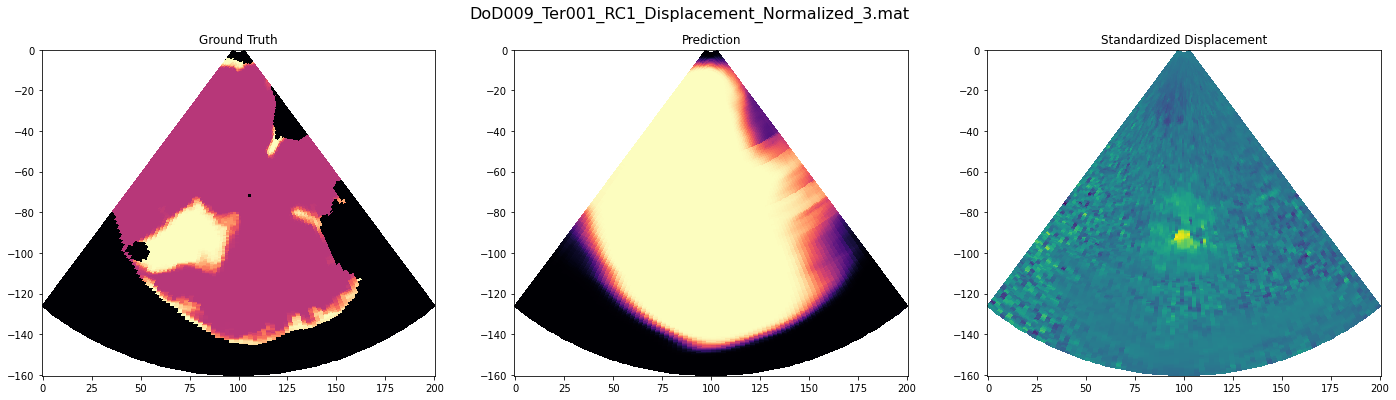

In [21]:
show_specific_prediction('DoD009_Ter001_RC1_Displacement_Normalized_3.mat',
                         '/DATA/phan92/tbi_diagnosis/data/processed/displacementNorm_data.hdf5',
                         model_2)

/tmp/ipykernel_1156/3652052533.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma')
/tmp/ipykernel_1156/3652052533.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(xAxis, -yAxis, prediction, shading='auto', cmap='magma')
/tmp/ipykernel_1156/3652052533.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to p

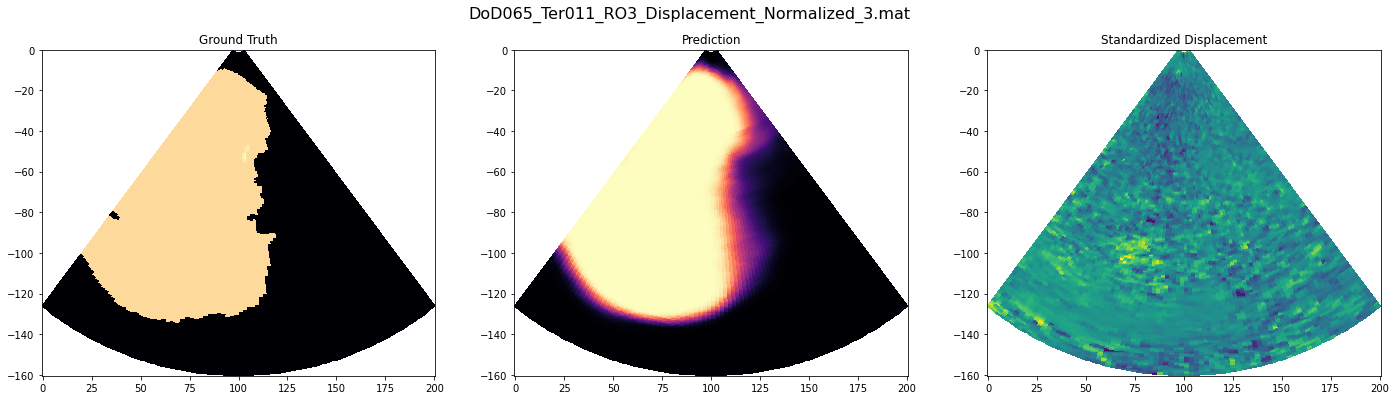

In [31]:
dataset = h5py.File('/DATA/phan92/tbi_diagnosis/data/processed/displacementNorm_data.hdf5', 'r')
show_prediction(model_2, dataset['test'], 110)
dataset.close()

In [ ]:
loss, dice = cross_validation(10, '/DATA/phan92/tbi_diagnosis/data/processed/displacementNorm_data.hdf5', 50)

In [ ]:
loss

In [ ]:
dice